# Проверка гипотез по увеличению выручки в интернет-магазине — оценить результаты A/B теста

**Описание проекта**  

Несмотря на огромные вложения в рекламу приложения Procrastinate Pro+, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.  

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.  

Предстоит изучить:  
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.  

**Описание данных**  

В распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.  

Структура `visits_info_short.csv`:
* `User Id` — уникальный идентификатор пользователя,
* `Region` — страна пользователя,
* `Device` — тип устройства пользователя,
* `Channel` — идентификатор источника перехода,
* `Session Start` — дата и время начала сессии,
* `Session End` — дата и время окончания сессии.  

Структура `orders_info_short.csv`:
* `User Id` — уникальный идентификатор пользователя,
* `Event Dt` — дата и время покупки,
* `Revenue` — сумма заказа.  

Структура `costs_info_short.csv`:
* `dt` — дата проведения рекламной кампании,
* `Channel` — идентификатор рекламного источника,
* `costs` — расходы на эту кампанию.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')

In [3]:
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')

In [4]:
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Пропуски в таблице отсутствуют. Для удобной работы с данными приведем названия столбцов к нижнему регистру и заменим пробелы на нижнее подчеркивание. Для работы с данными о начале и конце сессии изменим тип данных в соответствующих столбцах на datetime.

In [6]:
visits.columns = visits.columns.str.lower()
visits.columns = visits.columns.str.replace(' ', '_')
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Проверим таблицу на наличие дубликатов.

In [7]:
visits.duplicated().sum()

0

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Пропуски в таблице отсутствуют. Для удобной работы с данными приведем названия столбцов к нижнему регистру и заменим пробелы на нижнее подчеркивание. Для работы с данными о времени изменим тип данных в соответствующих столбцах на datetime.

In [9]:
orders.columns = orders.columns.str.lower()
orders.columns = orders.columns.str.replace(' ', '_')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

Проверим таблицу на наличие дубликатов.

In [10]:
orders.duplicated().sum()

0

In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропуски в таблице отсутствуют. Для удобной работы с данными приведем названия столбцов к нижнему регистру и заменим пробелы на нижнее подчеркивание. Для работы с данными о времени изменим тип данных в соответствующих столбцах на datetime.

In [12]:
costs.columns = costs.columns.str.lower()
costs.columns = costs.columns.str.replace(' ', '_')
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Проверим таблицу на наличие дубликатов.

In [13]:
costs.duplicated().sum()

0

Данные подготовлены к работе.

### Задание функций для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Объявление функций

##### Функции для вычисления значений метрик

**get_profiles()** — для создания профилей пользователей

In [14]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


**get_retention()** — для подсчёта Retention Rate

In [15]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**get_conversion()** — для подсчёта конверсии

In [16]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**get_ltv()** — для подсчёта LTV

In [17]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

##### Функции для построения графиков

**filter_data()** — для сглаживания данных

In [18]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**plot_retention()** — для построения графика Retention Rate

In [19]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**plot_conversion()** — для построения графика конверсии

In [20]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**plot_ltv_roi** — для визуализации LTV и ROI

In [21]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

#### Профили пользователей

In [22]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,False,0.230769


In [23]:
print('Минимальная дата привлечения пользователей: ', profiles['dt'].min())
print('Максимальная дата привлечения пользователей: ', profiles['dt'].max())

Минимальная дата привлечения пользователей:  2019-05-01
Максимальная дата привлечения пользователей:  2019-10-27


**Профили пользователей сформированы. Данные представлены за неполные 6 месяцев: с начала мая по 27 октября 2019 года. Из описания проекта следует, что компания терпит убытки последние несколько месяцев, это значит что данные актуальны и для проведения исследования их достаточно.**

#### Распрделение по странам

Объявим функцию, которая принимает на входе интересующий нас параметр из таблицы profiles и возвращает таблицу, сгруппированную по интересующему параметру с количеством пользователей и процентом платящих пользователей.

In [24]:
def stat(parametr):
    stat = profiles.groupby(parametr).agg({'payer': ['sum', 'count']})
    stat.columns = ['sum', 'count']
    stat['payers, %'] = round(stat['sum'] / stat['count'] * 100, 2)
    stat = stat.drop(columns = 'sum')
    return stat

Рассчитаем долю платящих клиентов для каждой страны.

In [25]:
region_stat = stat('region')
region_stat

,count,"payers, %"
region,,
France,17450,3.80
Germany,14981,4.11
UK,17575,3.98
United States,100002,6.90


**Количество пользователей и процент платящих пользователей из Франции, Германии и Великобритании примерно равны. Больше всего пользователей из США, платящих среди них так же значительно больше.**

#### Устройства

Рассчитаем долю платящих клиентов для каждого устройства.

In [26]:
region_stat = stat('device')
region_stat

,count,"payers, %"
device,,
Android,35032,5.85
Mac,30042,6.36
PC,30455,5.05
iPhone,54479,6.21


**Самая малая доля платящих клиентов среди пользователей PC, самая большая - у пользователей Mac. Разброс среди пользователей Android, Mac и iPhone составляет всего 0,5%.**

#### Рекламные источники

In [27]:
region_stat = stat('channel')
region_stat

,count,"payers, %"
channel,,
AdNonSense,3880,11.34
FaceBoom,29144,12.20
LeapBob,8553,3.06
MediaTornado,4364,3.57
OppleCreativeMedia,8605,2.71
RocketSuperAds,4448,7.91
TipTop,19561,9.60
WahooNetBanner,8553,5.30
YRabbit,4312,3.83


**Наблюдаем большой разброс показателей платящих пользователей по каналам привлечения. Присутствуют явные лидеры и аутсайдеры. Показатели из некоторых рекламных источников приносят выручку немногим чаще, чем пользователи, пришедшие в приложение самостоятельно. При этом клиентов, привлеченных такими источниками с невысокими показателями, в некоторых случаях даже больше, чем у каналов привлечения c высоким процентом платящих пользователей.**

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

#### Общая сумма расходов на маркетинг

In [28]:
print('Общая сумма расходов на маркетинг ', round(costs['costs'].sum()), 'у.е.')

Общая сумма расходов на маркетинг  105497 у.е.


#### Распределение трат по рекламным источникам

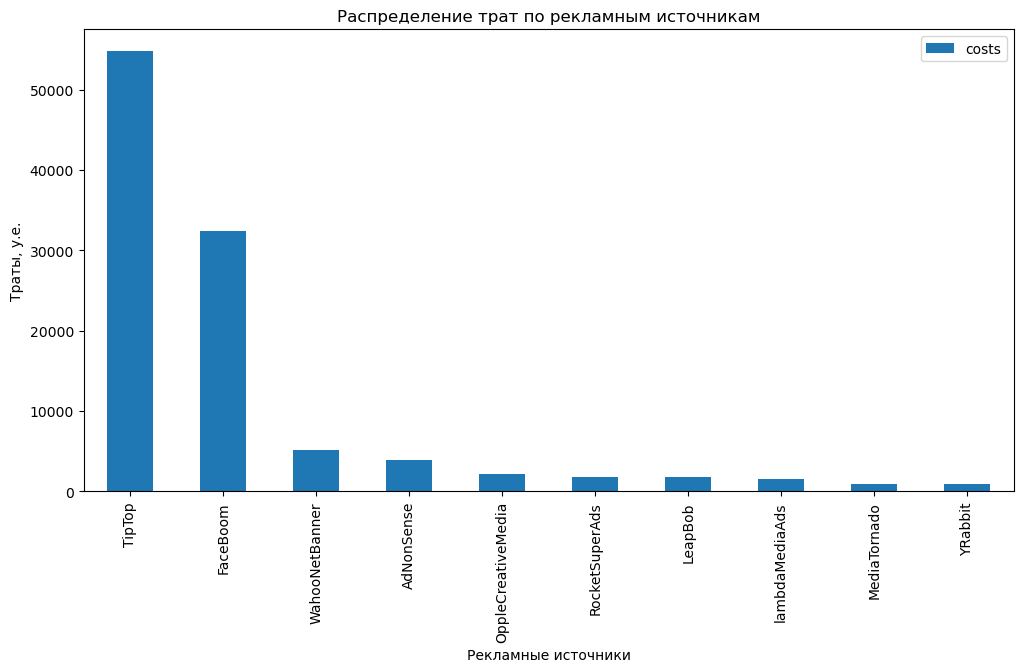

In [29]:
channel_costs = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False).reset_index()
channel_costs.plot(x='channel', y='costs', kind='bar', title='Распределение трат по рекламным источникам', figsize=(12, 6))
plt.xlabel('Рекламные источники')
plt.ylabel('Траты, у.е.')
plt.show()

**Больше всего средств было потрачено на продвижение в каналах TipTop и FaceBoom.**

#### Динамика изменения расходов на рекламу во времени по каждому источнику

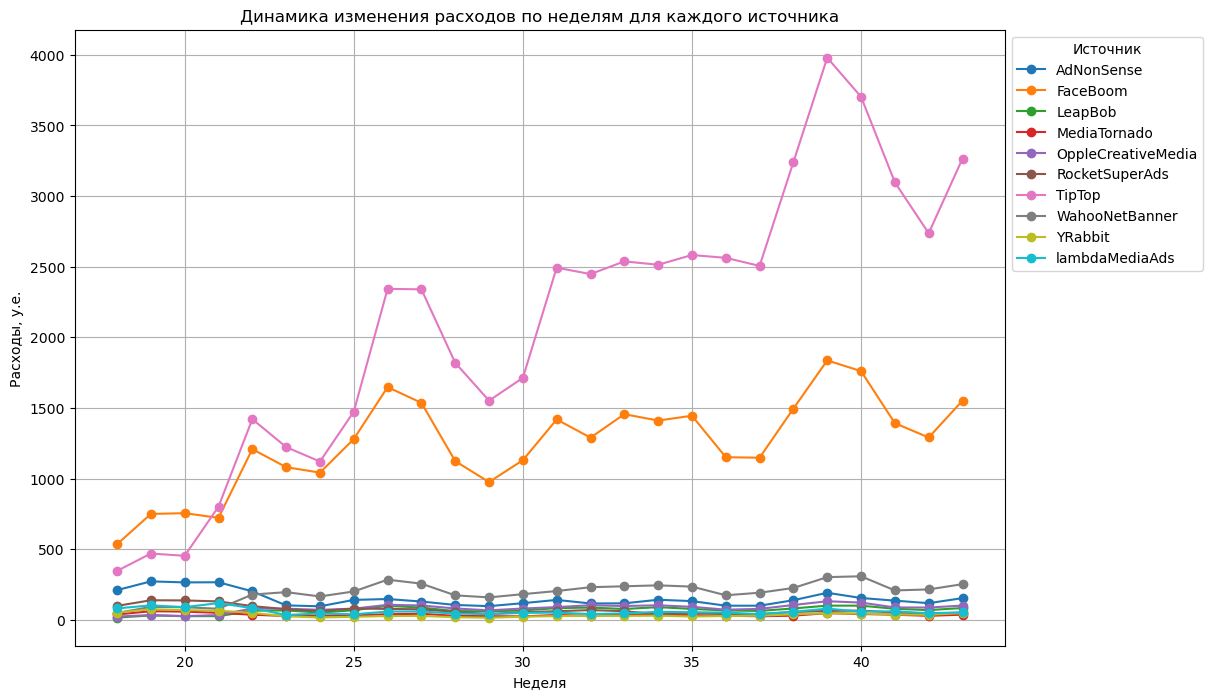

In [30]:
costs['week'] = costs['dt'].apply(lambda x: x.isocalendar()[1])

# Группировка данных по источнику рекламы и неделе, и суммирование расходов
grouped_week = costs.groupby(['channel', 'week'])['costs'].sum().unstack()

# Построение графика для каждого источника рекламы
grouped_week.T.plot(kind='line', marker='o', figsize=(12, 8), grid=True)
plt.title('Динамика изменения расходов по неделям для каждого источника')
plt.xlabel('Неделя')
plt.ylabel('Расходы, у.е.')
plt.legend(title='Источник', bbox_to_anchor=(1, 1))
plt.show()

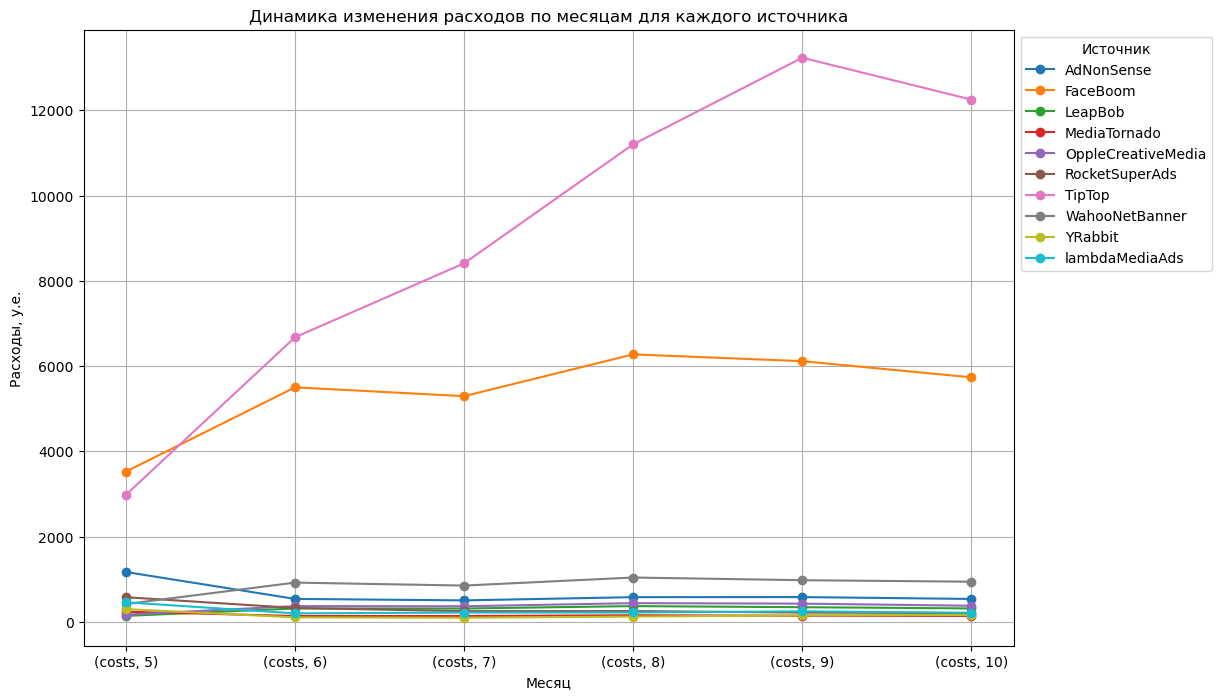

In [31]:
costs['month'] = costs['dt'].apply(lambda x: x.month)
grouped_month = costs.groupby(['channel', 'month']).agg({'costs': 'sum'}).unstack()
grouped_month.T.plot(kind='line', marker='o', figsize=(12, 8), grid=True)
plt.title('Динамика изменения расходов по месяцам для каждого источника')
plt.xlabel('Месяц')
plt.ylabel('Расходы, у.е.')
plt.legend(title='Источник', bbox_to_anchor=(1, 1))
plt.show()

**На канал TipTop от месяца к месяцу тратилось все больше рекламных средств, кроме последнего (неполного) месяца, на FaceBoom наблюдается рост до августа, а после траты незначительно снижаются. На остальные каналы расходы практически не изменялись.**

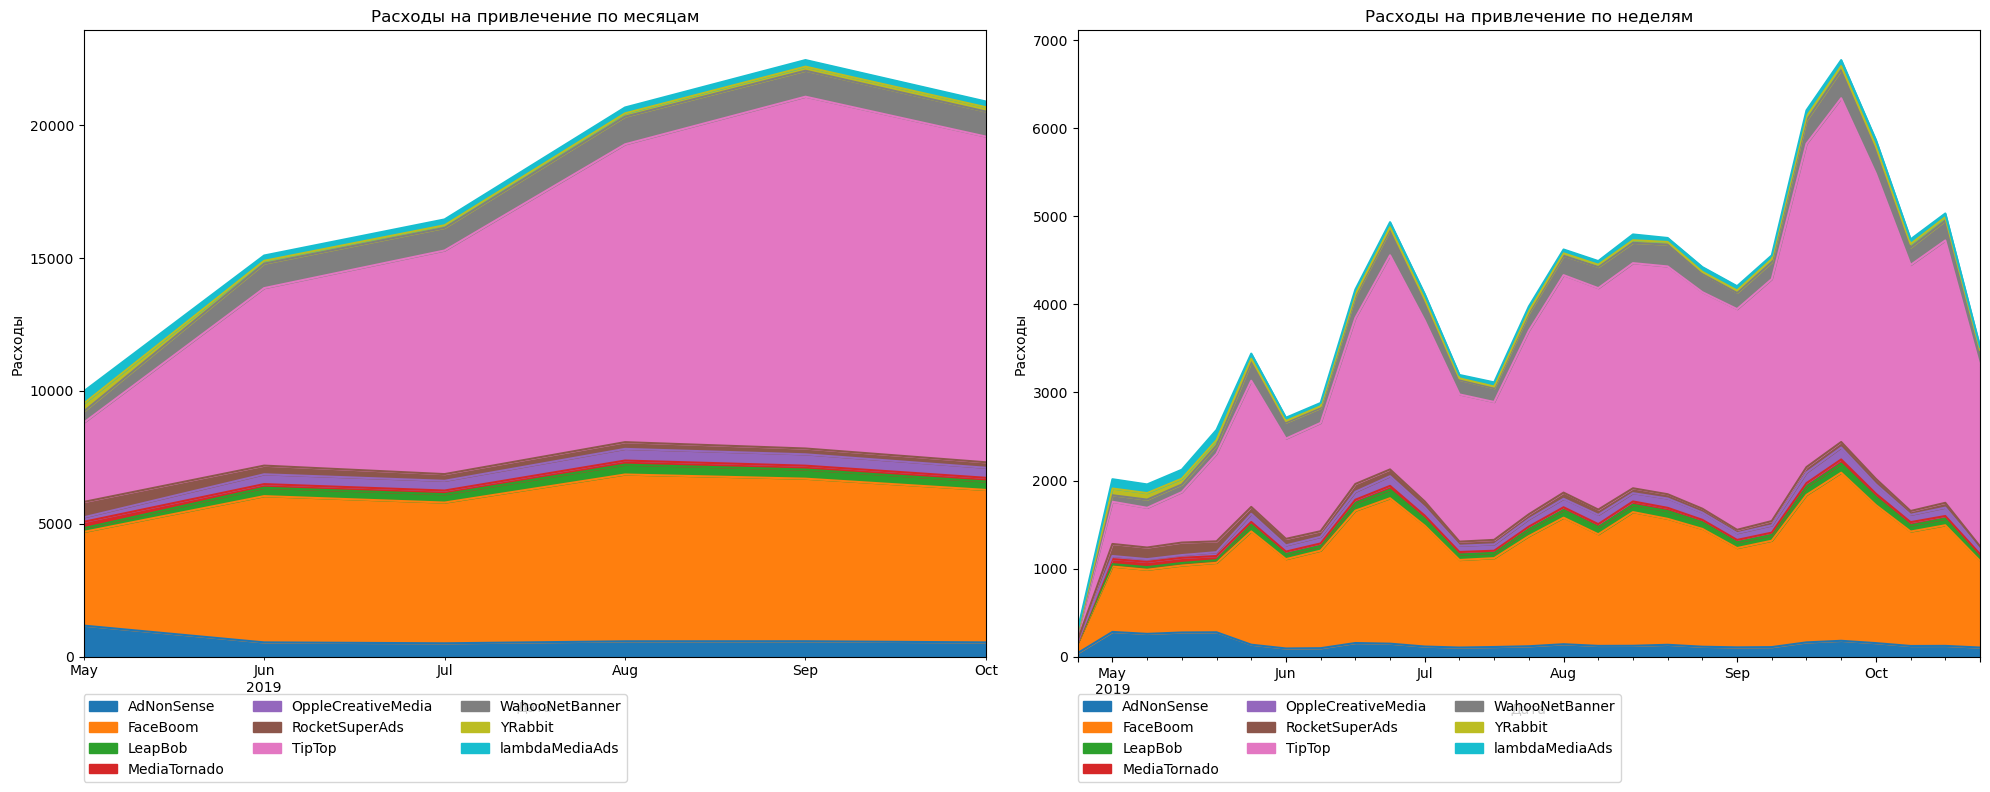

In [32]:
costs['Расходы на привлечение по месяцам'] = costs['dt'].astype('datetime64[M]')
costs['Расходы на привлечение по неделям'] = costs['dt'].astype('datetime64[W]')

columns = ['Расходы на привлечение по месяцам', 'Расходы на привлечение по неделям']

fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # Увеличиваем размер фигуры

for i, col in enumerate(columns):
    ax = axs[i]
    costs.pivot_table(index=col, columns='channel', values='costs', aggfunc='sum').plot.area(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Дата')
    ax.set_ylabel('Расходы')
    ax.legend(ncol=3, bbox_to_anchor=(0, -0.2), loc='lower left', borderaxespad=0)

plt.tight_layout()
plt.show()

#### Стоимость привлечения одного пользователя (CAC) из каждого источника

In [33]:
users_count = profiles.groupby('channel').agg({'user_id': 'count'})
channel_costs = costs.groupby('channel').agg({'costs': 'sum'})
mean_cac = users_count.merge(channel_costs, on='channel', how='right')
mean_cac['cac'] = round(mean_cac['costs']/mean_cac['user_id'], 3)
mean_cac = mean_cac.sort_values(by='cac')
mean_cac

,user_id,costs,cac
channel,,,
LeapBob,8553,1797.60,0.210
MediaTornado,4364,954.48,0.219
YRabbit,4312,944.22,0.219
OppleCreativeMedia,8605,2151.25,0.250
RocketSuperAds,4448,1833.00,0.412
WahooNetBanner,8553,5151.00,0.602
lambdaMediaAds,2149,1557.60,0.725
AdNonSense,3880,3911.25,1.008
FaceBoom,29144,32445.60,1.113


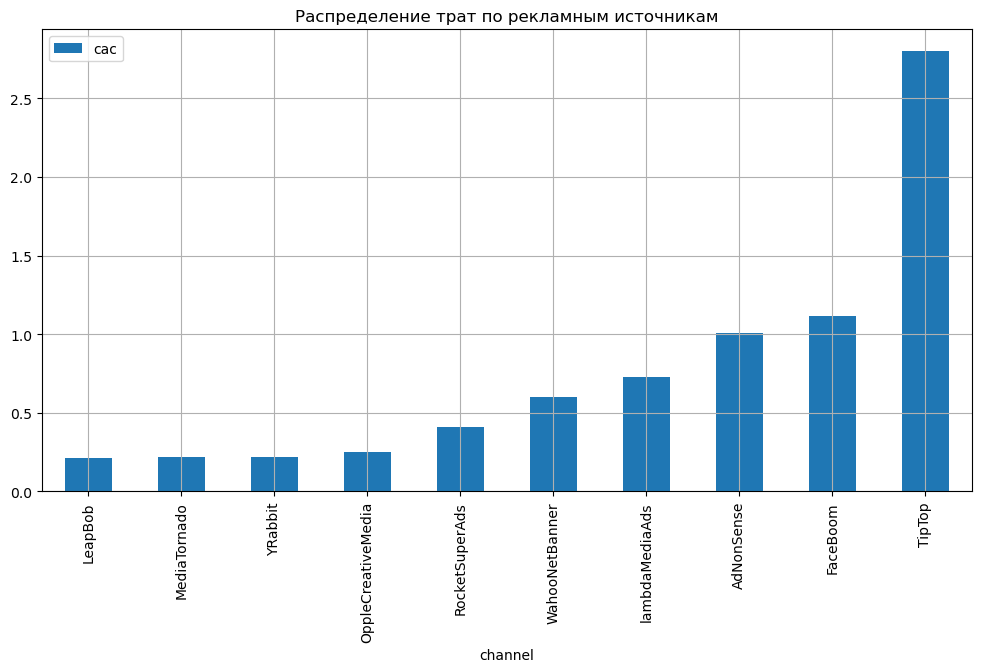

In [34]:
mean_cac.reset_index().plot(
    x='channel', y='cac', kind='bar', title='Распределение трат по рекламным источникам', figsize=(12, 6), grid=True
)
plt.show()

**Самые дорогие клиенты привлекаются каналом TipTop, самые дешевые - LeapBob. Стоимость привлечения одного клиента каналом TipTop выше более чем в два раза по сравнению с ближайшим FaceBoom.**

### Окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

#### 
Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

Исключим профили органических пользователей, т.к. мы изучаем именно эффективность рекламных каналов и органические пользователи могут исказить картину.

In [35]:
profiles_ad = profiles[profiles['channel'] != 'organic'].copy()

In [36]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

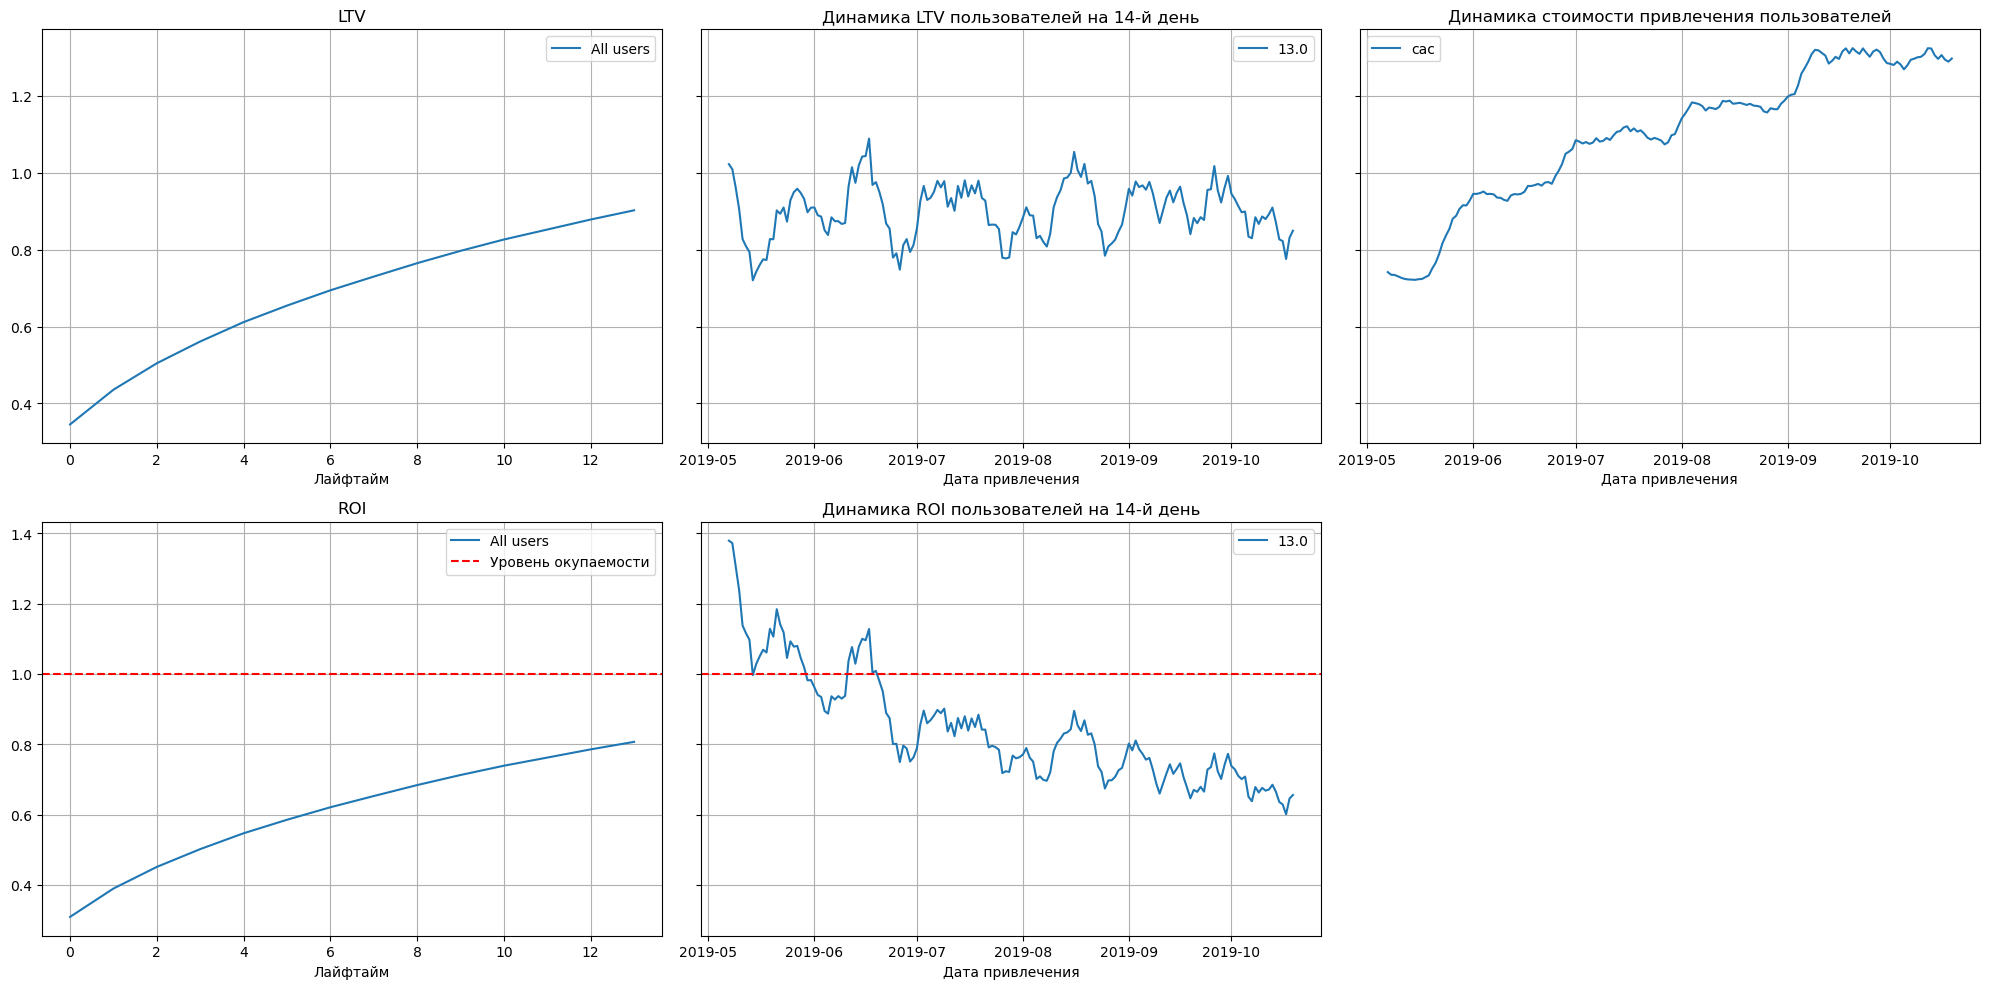

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Стоимость привлечения растет от месяца к месяцу при этом ROI падает (т.к. LTV держится примерно в одном диапазоне). Реклама не окупается, т.к. ROI не доходит до уровня окупаемости в течении двух недель.**

#### 
Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

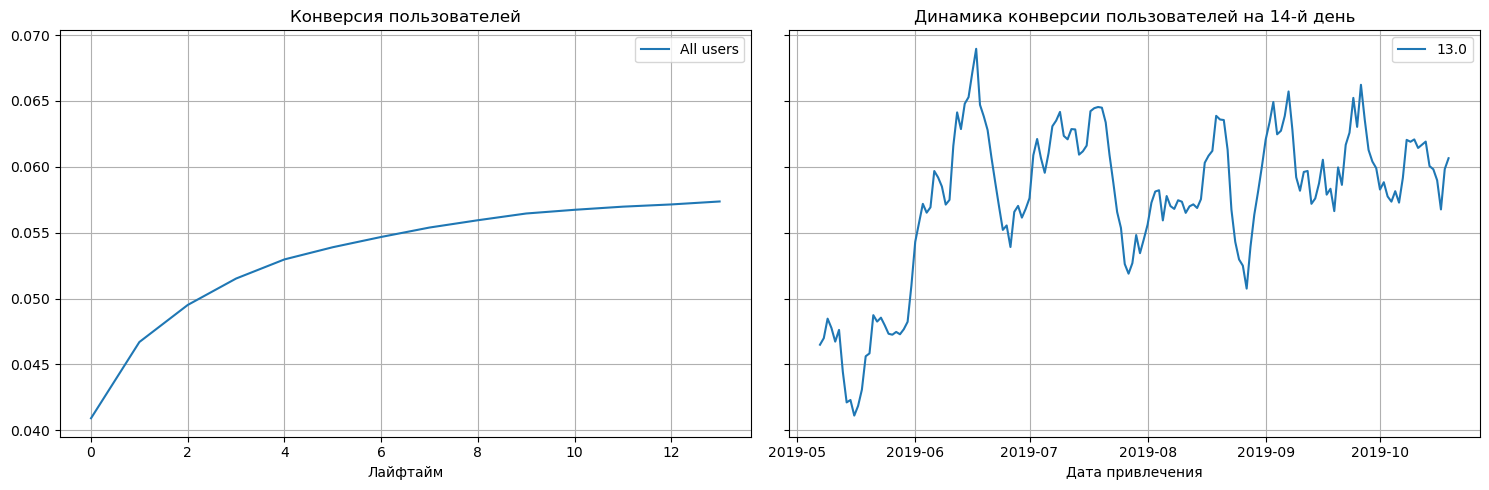

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**На графике конверсии пользователей аномалий не выявлено. В динамике конверсия непостоянна от недели к неделе, но в среднем выше, чем в мае.**

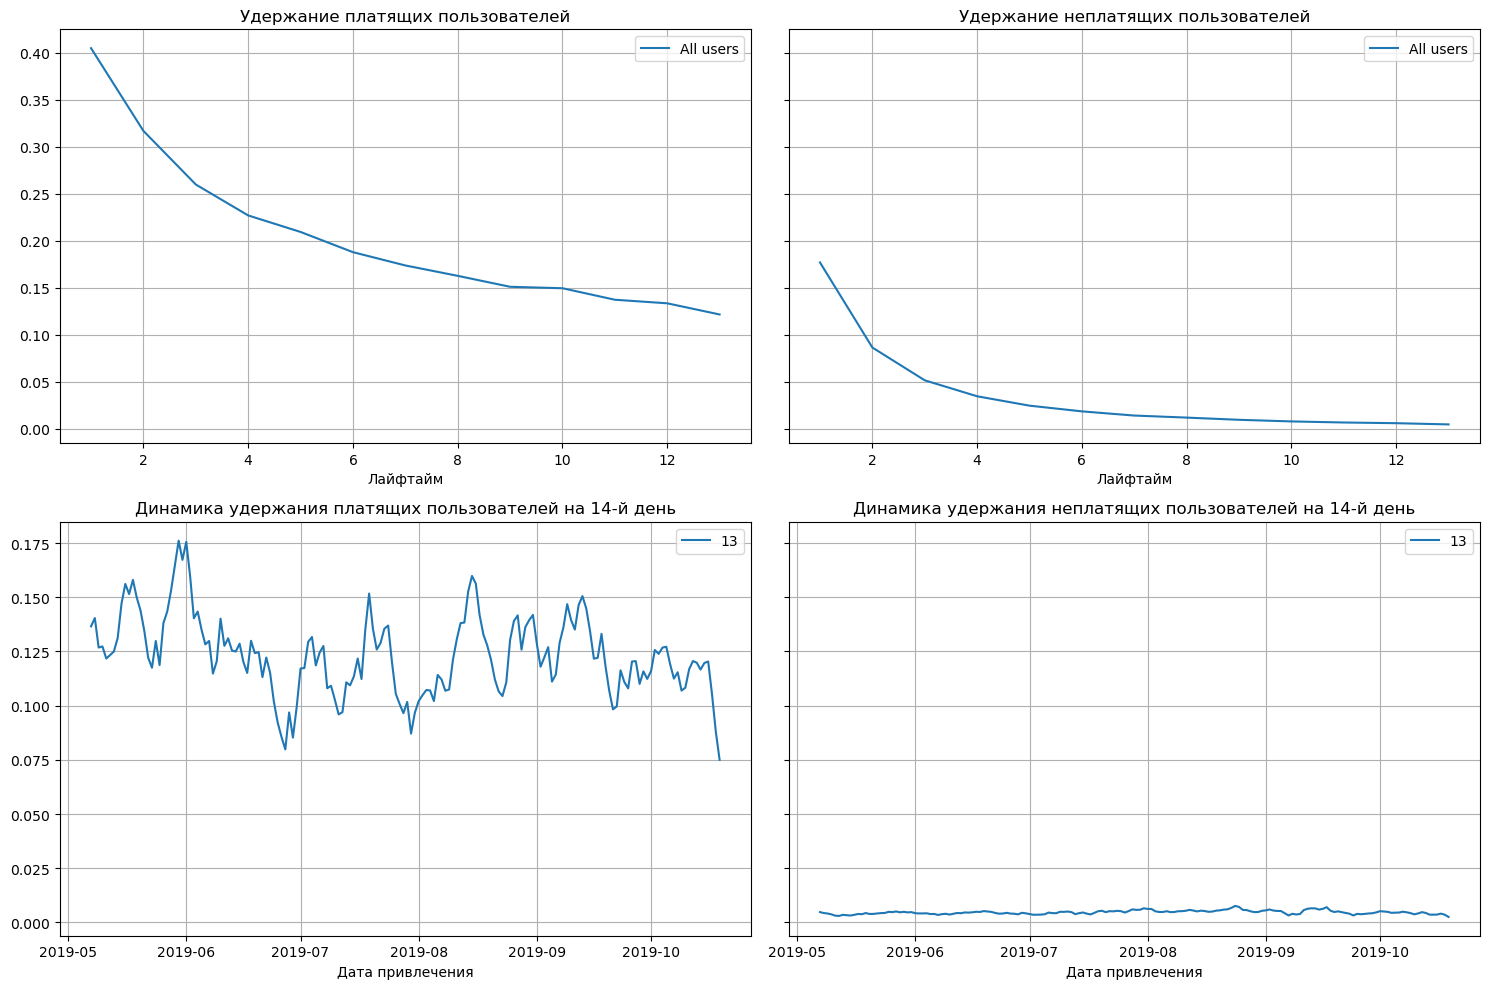

In [39]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Аномалий на графиках не выявлено. В среднем удержание платящих пользователей за последние месяцы ниже, чем в начале исследуемого периода.**

Построим графики с разбивкой по каналам привлечения.

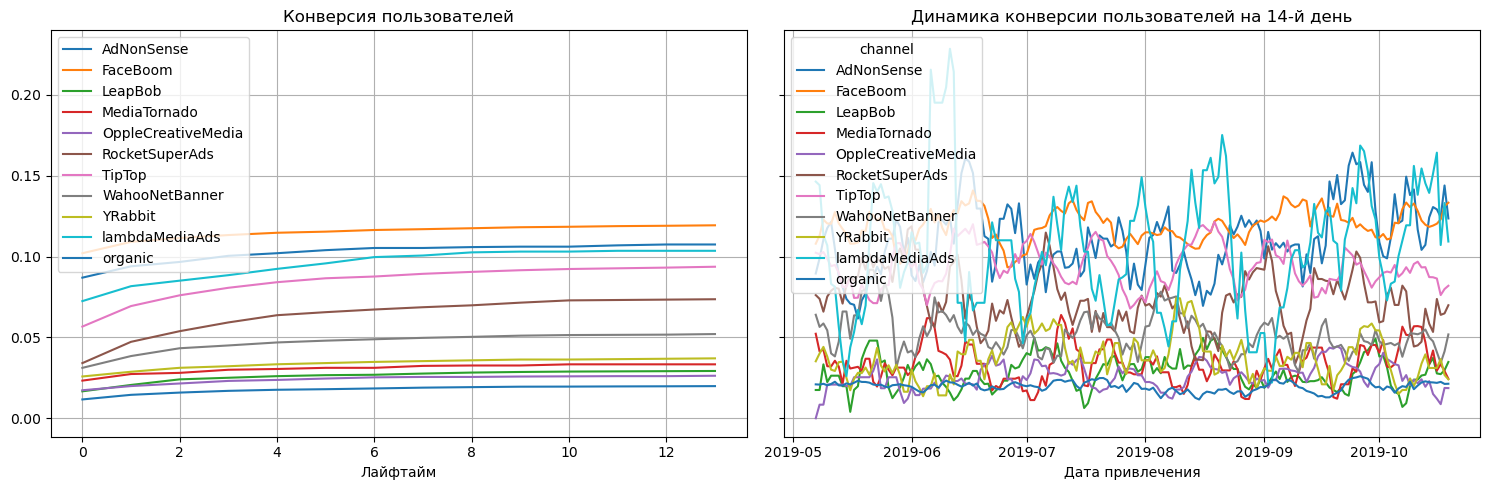

In [40]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

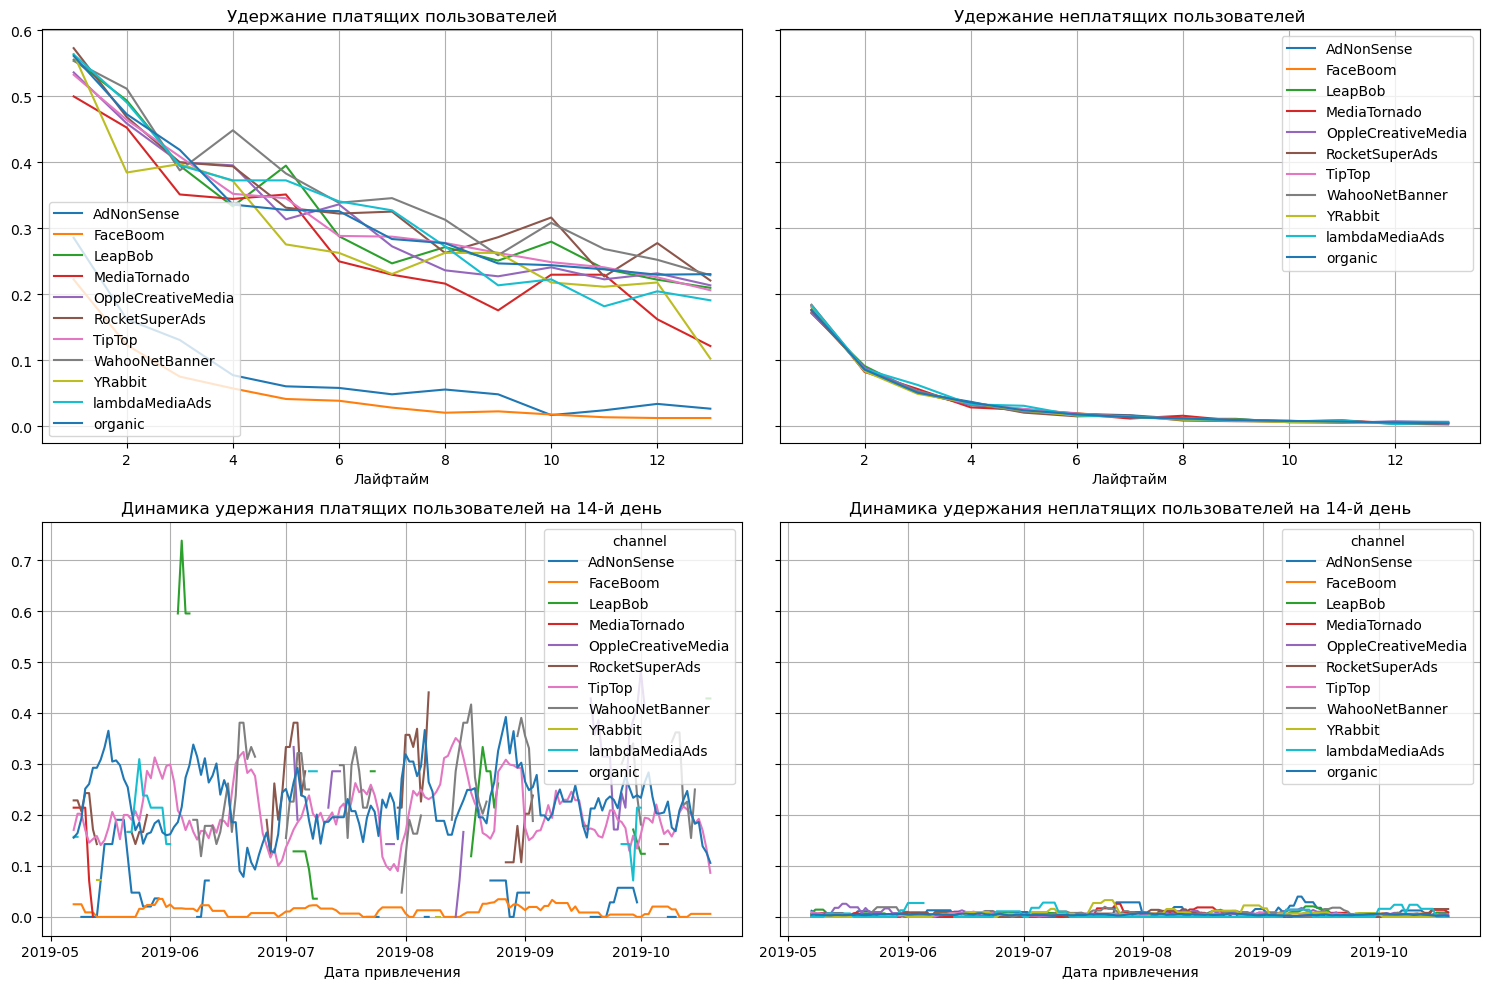

In [41]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Наблюдается аномально низкий показатель удержания платящих пользователей, пришедших с канала FaceBoom.**

#### 
Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

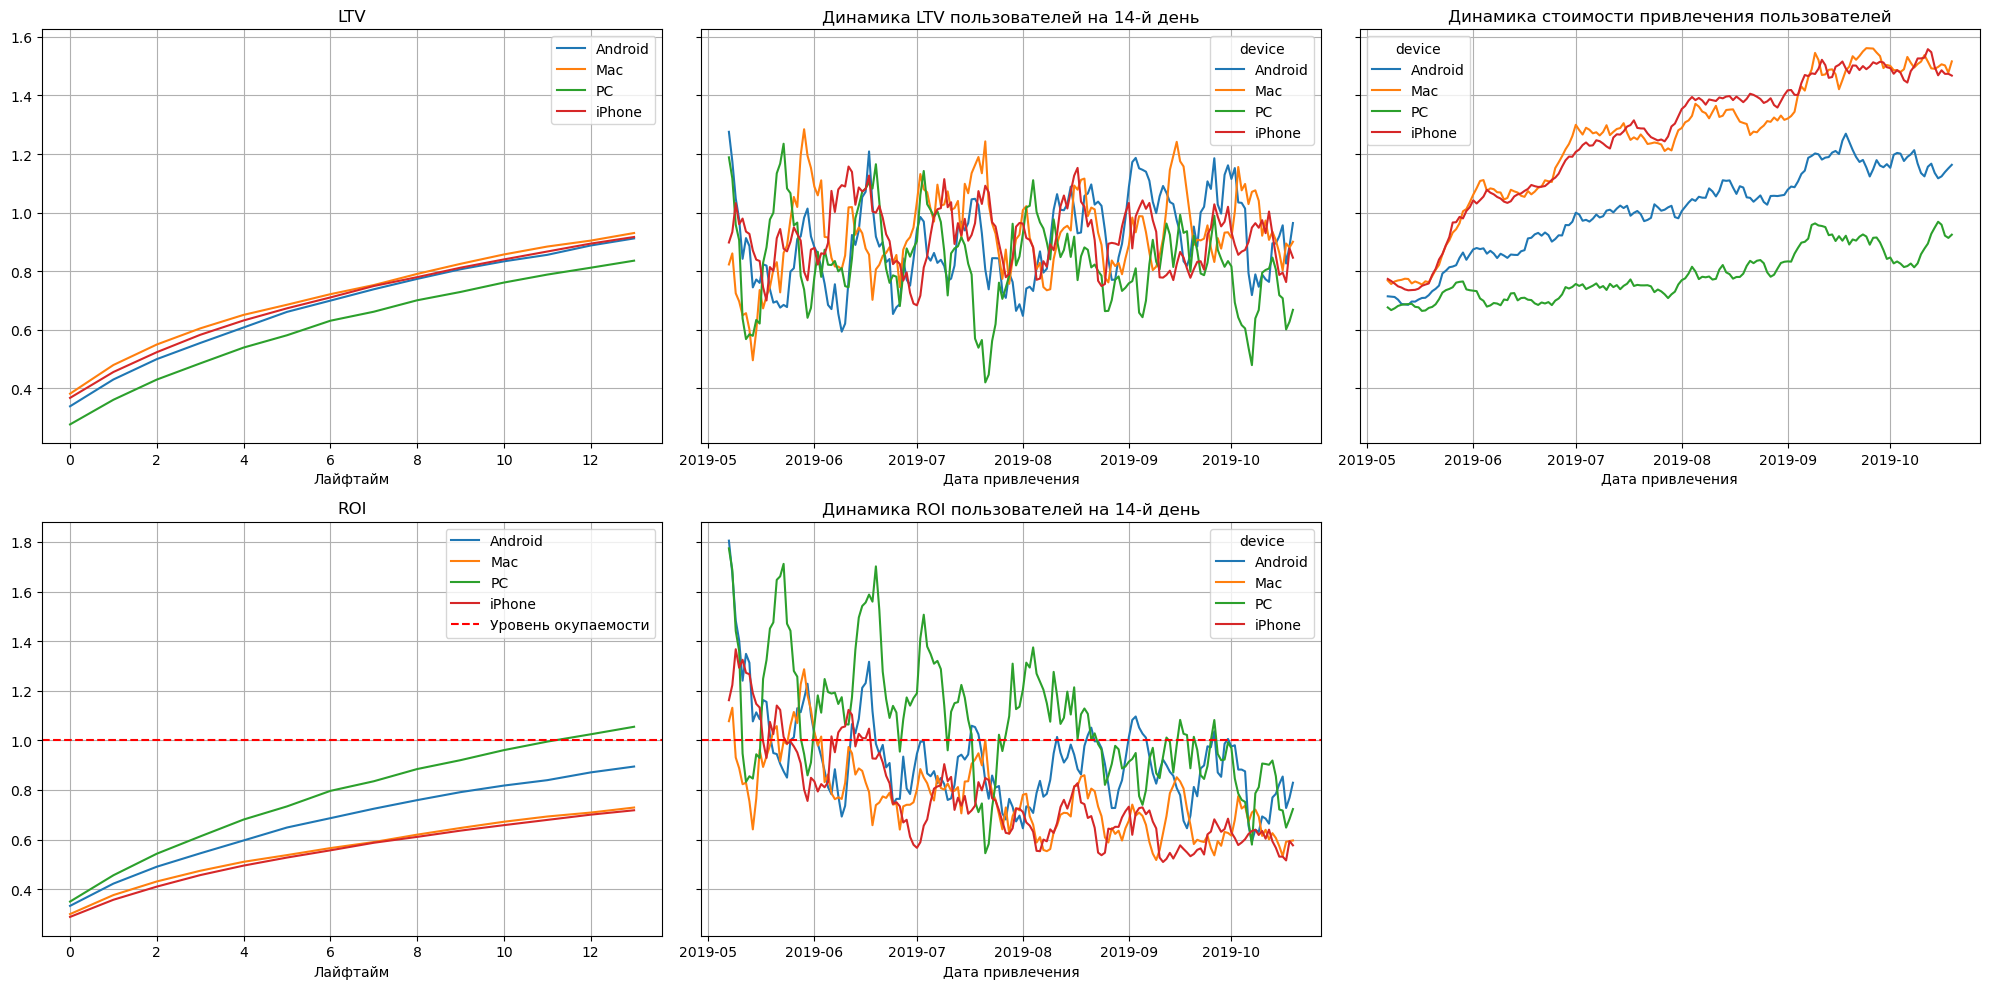

In [42]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Реклама окупается только для ползователей PC, средний результат для пользователей Android, аутсайдеры - Mac и iPhone. Стоимость привлечения резко растет для iPhone и Mac начиная с мая, постепенно растет для Android и меньше всего растет для пользователей PC. ROI падает с мая и к ноябрю уровень окупаемости не превышает ни одна платформа.**

#### 
Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

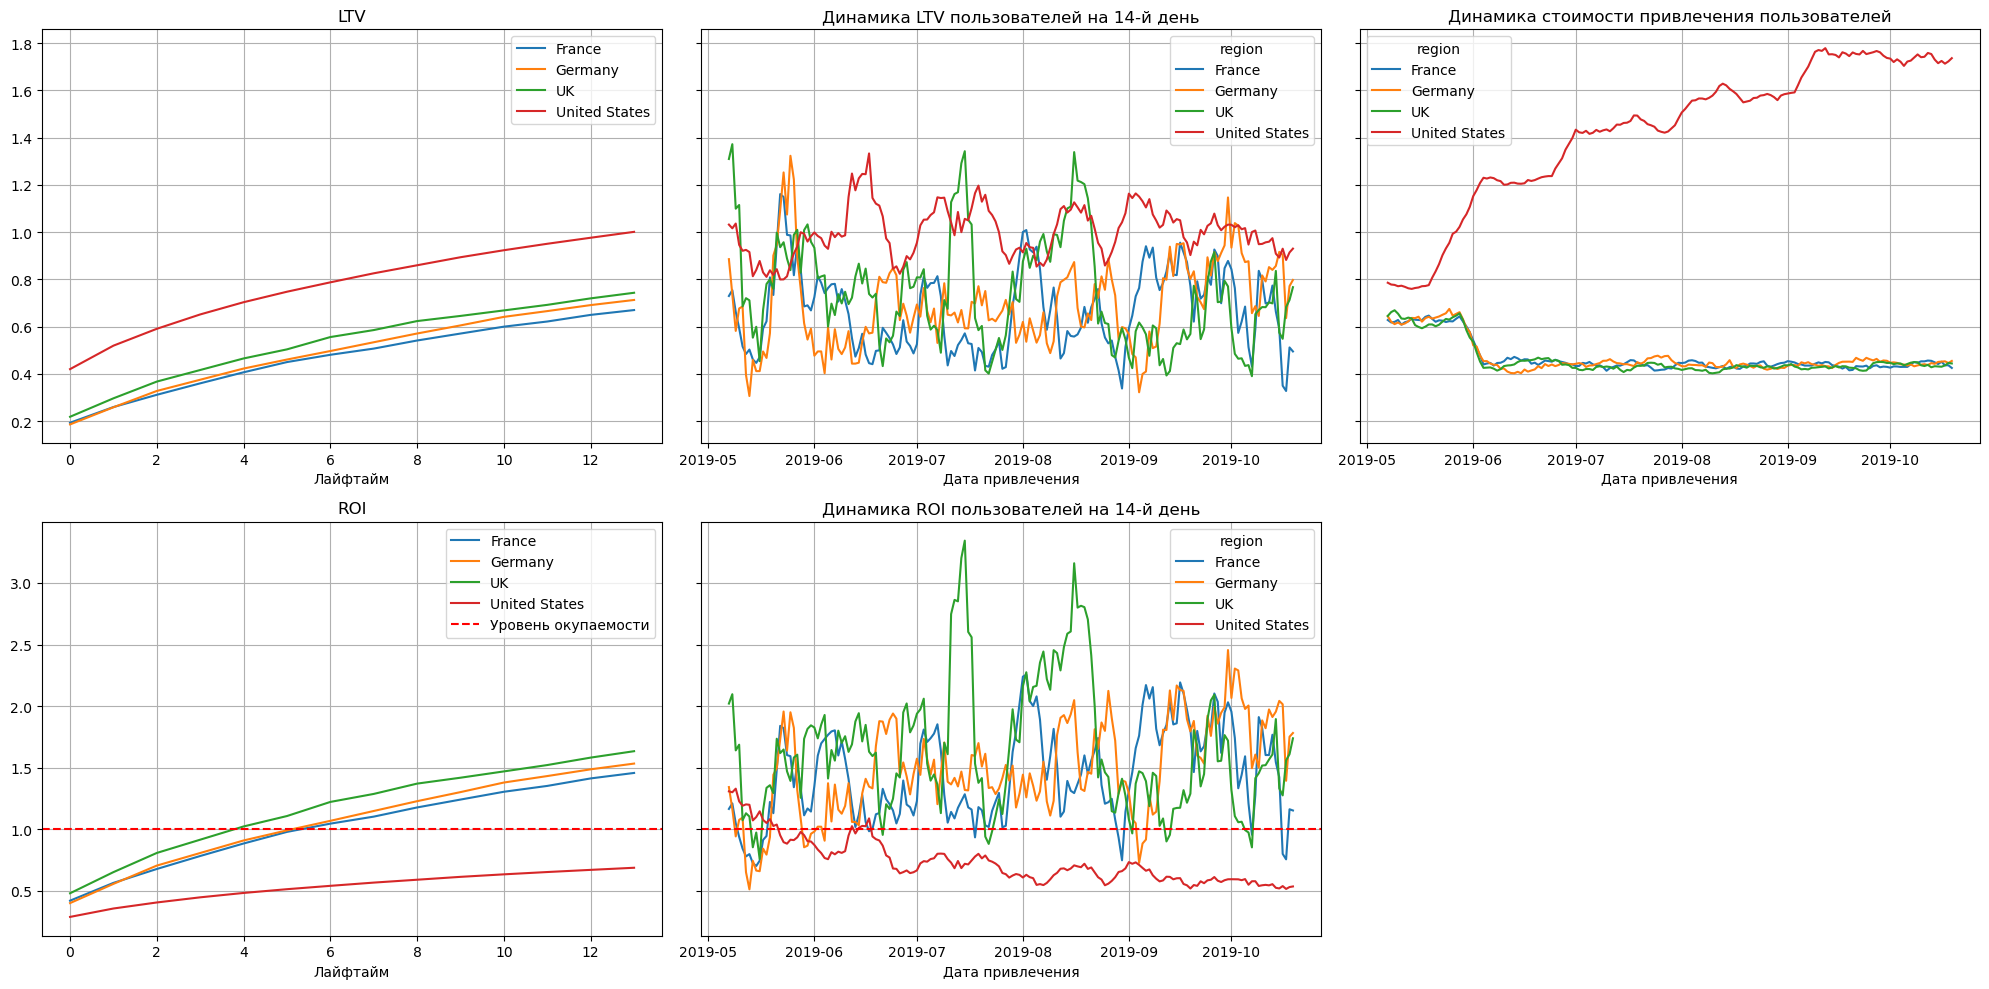

In [43]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**LTV выше всего у пользователей из США, для остальных стран отличается не сильно. Но при этом начиная с мая стоимость привлечения пользоватилей из США растет и кратно выше стоимости привлечения клиентов из других стран. Стоимость привлечения клиентов из Великобритании, Германии и Франции в мае наоборот упала и держится на одном уровне. Пользователи всех стран окупаются уже начианая с 4-го - 6-го дня, кроме пользователей из США, которые не окупаются вовсе.**

#### 
Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

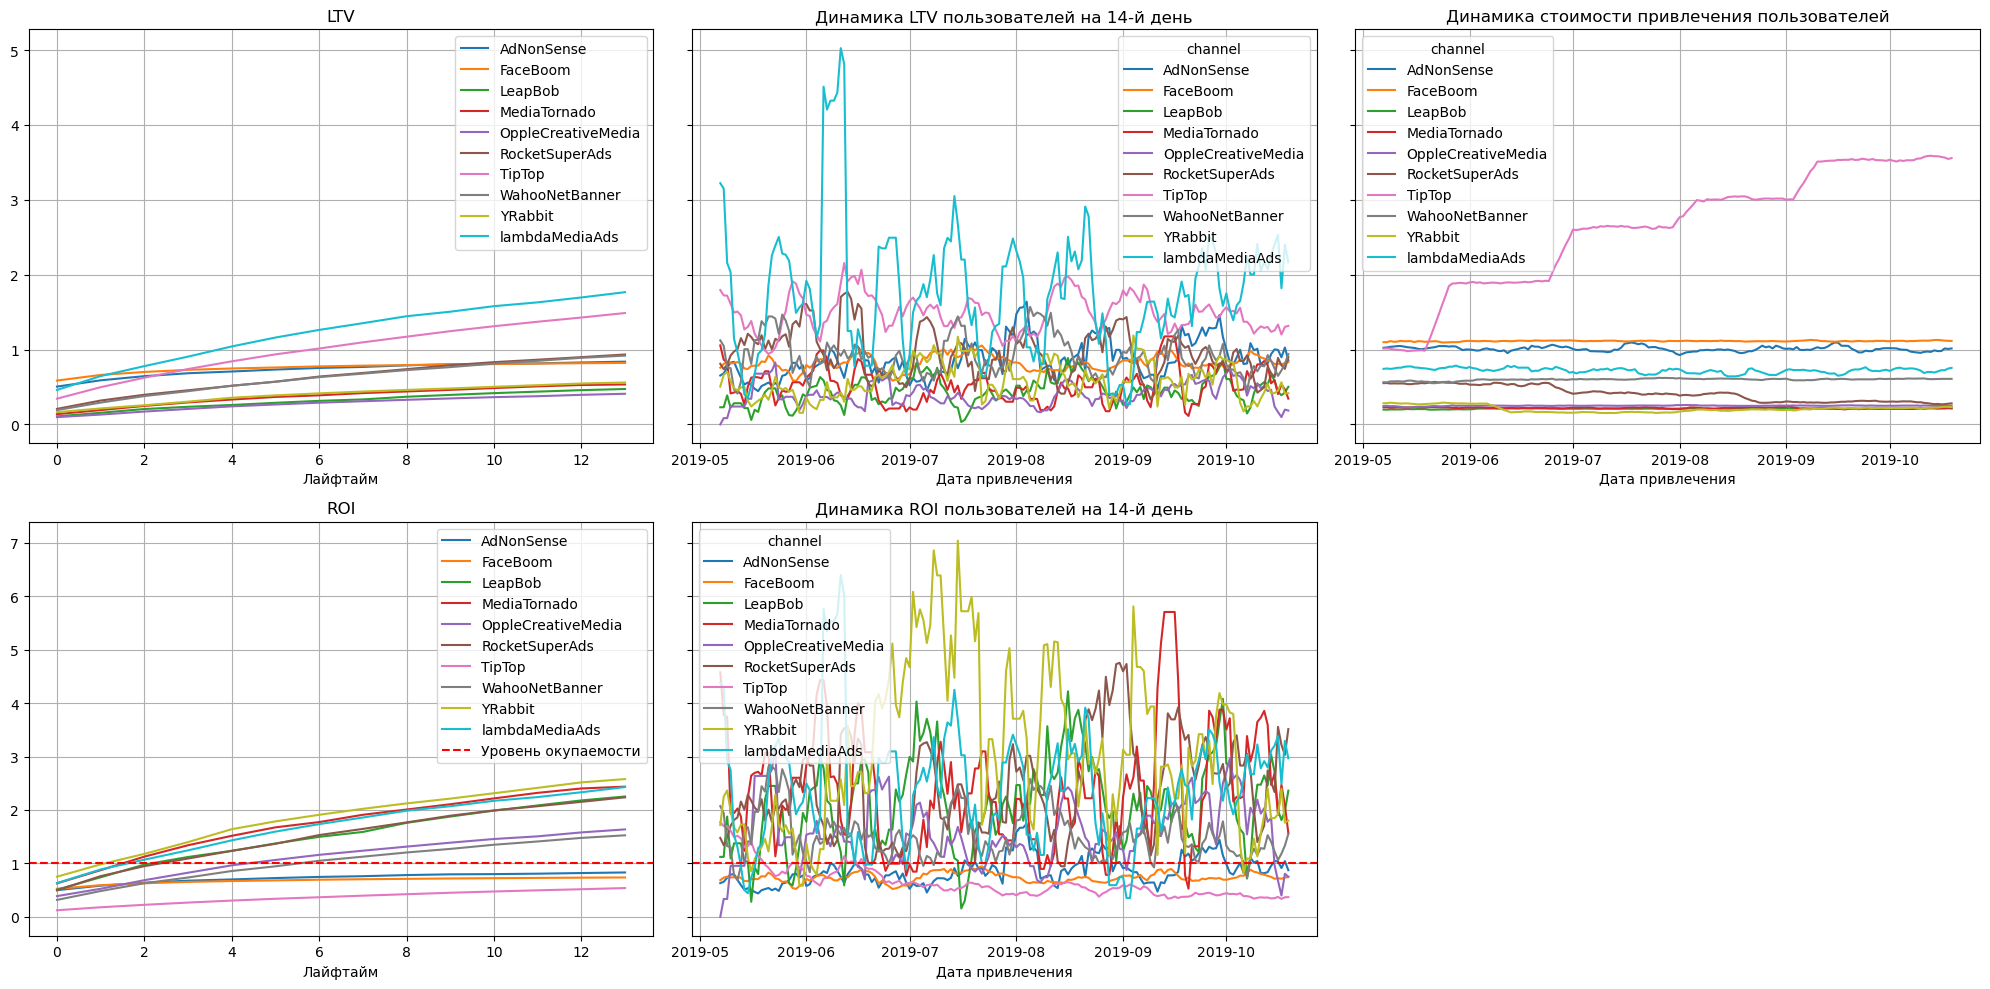

In [44]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Стоимость привлечения клиентов через канал TipTop растет с каждым месяцем и кратно превышает стоимость привлечения клиентов из других каналов. Кроме TipTop не окупаются FaceBoom и LeapBob. Средние показатели у OppleCreativeMedia и WahooNetBanner, которые окупаются за 4-5 дней, показатель ROI около 1,5. Все остальные каналы работают отлично, окупаются в среднем за 2 дня и имеют ROI 2,2-2,6.**

#### Вопросы
* Окупается ли реклама, направленная на привлечение пользователей в целом?

Ответ: Реклама в целом не окупается.

* Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Ответ: Негативное влияние на окупаемость оказывают пользователи Mac и iPhone, пользователи из США и пользователи, привлеченные каналами TipTop, FaceBoom и LeapBob. Стоимость привлечения клиентов через канал TipTop слишком высока, а у клиентов, привлеченных каналом FaceBoom, показатель удержания платящих пользователей кратно ниже, чем у остальных каналов и даже ниже, чем у органических пользователей. Пользователи Android также не окупаются, но имеют показатели средние между лидером и аутсайдерами.

* Чем могут быть вызваны проблемы окупаемости?

Ответ: Высокая стоимость привлечения клиентов отдельных когорт (по региону, по каналу привлечения, по устройству) и низкое качество пользователей, привлеченных определенными рекламными каналами.

**Вывод: в целом рекламные компании не окупаются. В ходе анализа были выявлены рекламные источники, пользователи конкретной страны и устройств, которые не окупаются.**

* Возможно приложение хуже оптимизировано для платформ-аутсайдеров. 
* Стоимость привлечения клиентов из США может быть тесно связана с конкретными рекламными каналами, необходим более глубокий анализ.
* Необходимо изучить подробнее каналы привлечения, которые не окупаются

**Причины неэффективности привлечения пользователей:**
1. Высокая стоимость привлечения пользователей из США.
2. Неокупаемость рекламных каналов TipTop, FaceBoom и LeapBob.

**Рекомендации для отдела маркетинга:**
1. Пересмотреть рекламные бюджеты на каналы привлечения пользователей в пользу более прибыльных источников, т.к. больше всего средств расходуется на TipTop и FaceBoom.
2. У FaceBoom лучший показатель конверсии пользователей, но самый низкий показатель удержания платящих пользователей. Следует изучить возможные причины данной проблемы и принять меры для повышения удержания пользователей.
3. Проверить оптимизацию приложений для Mac и iPhone.
4. Выяснить причины высокой стоимости рекламы в канале TipTop и как следствие высокой стоимости клиентов из США. Проработать возможные варианты снижения стоимости.